--- STEP 1: FETCHING DATA ---
Coordinates: [(71.907, 38.837)]

--- STEP 2: DATA TRANSPARENCY REPORT ---
Total Raw Data Points:    101774
Points after Cleaning:    11026 (Removed 90748 outliers/NaNs)
Data Range:               1990-03-01 to 2025-05-20
Total Duration:           12863 days (~35.2 years)
Average Frequency:        1 reading every 1.2 days (Mathematical Average)
Median Gap between pts:   0.0 days (Typical wait)
Maximum Gap (Missing):    584 days (Longest blind spot)

REALITY CHECK:
-> WARNING: Despite having 11026 points, you have gaps as large as 584.0 days.
-> This confirms you do NOT have a consistent reading every 2 days.

--- STEP 3: BUILDING CONSENSUS (Target k=3) ---
Testing Bin Frequency: 4D...
   -> Min Points (k): 1 | Coverage: 51.3% (Empty bins: 1567/3217)
   -> FAIL: k=1 is too low (Need >= 3).
Testing Bin Frequency: 8D...
   -> Min Points (k): 1 | Coverage: 64.5% (Empty bins: 571/1609)
   -> FAIL: k=1 is too low (Need >= 3).
Testing Bin Frequency: 16D...
   -> Mi

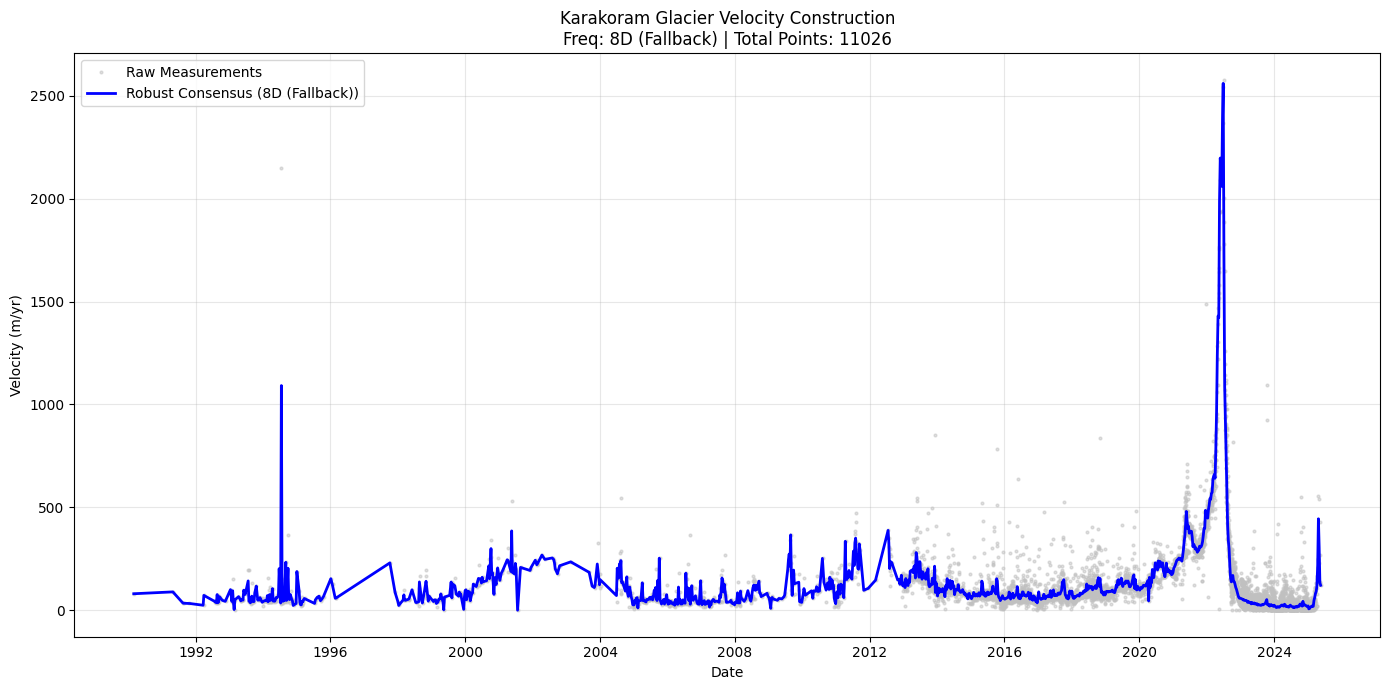


--- FINAL OUTPUT ---
Consensus Frequency Used: 8D (Fallback)
Total Time Steps Generated: 1609
This regularized time series is now ready for Period-Lagged Embedding (DMD).


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itslive import velocity_cubes

# ---------------------------------------------------------
# 1. TRANSPARENT DATA FETCHING & CLEANING
# ---------------------------------------------------------
coords = [(71.907, 38.837)] 
print(f"--- STEP 1: FETCHING DATA ---")
print(f"Coordinates: {coords}")

# Fetch data
raw_response = velocity_cubes.get_time_series(points=coords, variables=["v", "mid_date"])[0]
data = raw_response['time_series']

df = pd.DataFrame({
    'date': pd.to_datetime(data['mid_date']),
    'v': np.array(data['v'])
})

# CLEANING
df = df.sort_values('date') # Fix monotonic errors
initial_count = len(df)
df = df.dropna()
df = df[df['v'] < 5000]     # Remove cloud outliers
clean_count = len(df)

# ---------------------------------------------------------
# 2. DATA TRANSPARENCY REPORT (Answering your question)
# ---------------------------------------------------------
print(f"\n--- STEP 2: DATA TRANSPARENCY REPORT ---")
print(f"Total Raw Data Points:    {initial_count}")
print(f"Points after Cleaning:    {clean_count} (Removed {initial_count - clean_count} outliers/NaNs)")

if clean_count > 0:
    start_date = df['date'].iloc[0]
    end_date = df['date'].iloc[-1]
    duration = (end_date - start_date).days
    years = duration / 365.25
    avg_density = clean_count / duration

    print(f"Data Range:               {start_date.date()} to {end_date.date()}")
    print(f"Total Duration:           {duration} days (~{years:.1f} years)")
    print(f"Average Frequency:        1 reading every {1/avg_density:.1f} days (Mathematical Average)")
    
    # CALCULATE ACTUAL GAPS
    # This shows if you ACTUALLY have data every 2 days
    df['gap_days'] = df['date'].diff().dt.days
    max_gap = df['gap_days'].max()
    median_gap = df['gap_days'].median()
    
    print(f"Median Gap between pts:   {median_gap:.1f} days (Typical wait)")
    print(f"Maximum Gap (Missing):    {max_gap:.0f} days (Longest blind spot)")
    
    print("\nREALITY CHECK:")
    if max_gap > 30:
        print(f"-> WARNING: Despite having {clean_count} points, you have gaps as large as {max_gap} days.")
        print(f"-> This confirms you do NOT have a consistent reading every 2 days.")
    else:
        print("-> Data coverage is exceptionally consistent.")
else:
    print("-> ERROR: No data remains after cleaning.")

# ---------------------------------------------------------
# 3. ROBUST CONSENSUS BUILDER (Auto-Adjusting)
# ---------------------------------------------------------
def build_robust_consensus(df, target_k=3, n_iterations=100):
    """
    Tries to build a consensus time series.
    It loops through bin sizes (4 days -> 32 days) to find one 
    where the minimum number of points (k) is at least target_k (3).
    """
    print(f"\n--- STEP 3: BUILDING CONSENSUS (Target k={target_k}) ---")
    
    # We define the periods we are willing to accept
    # 4D = Ideal (Paper standard), 8D/16D = Acceptable fallbacks
    frequencies = ['4D', '8D', '16D', '32D']
    
    selected_freq = None
    selected_k = 0
    df_result = None

    for freq in frequencies:
        print(f"Testing Bin Frequency: {freq}...")
        
        grouper = df.groupby(pd.Grouper(key='date', freq=freq))
        counts = grouper['v'].count()
        
        # We only care about bins that actually cover the time range
        # Check bins that have ANY data
        populated_bins = counts[counts > 0]
        
        if populated_bins.empty:
            print(f"   -> No populated bins. Skipping.")
            continue
            
        # The 'k' for the paper is the MINIMUM count in any populated bin
        # (This is strict! If even ONE bin has 1 point, k=1)
        current_k = int(populated_bins.min())
        total_bins = len(counts)
        empty_bins = len(counts[counts == 0])
        coverage_pct = (len(populated_bins) / total_bins) * 100
        
        print(f"   -> Min Points (k): {current_k} | Coverage: {coverage_pct:.1f}% (Empty bins: {empty_bins}/{total_bins})")

        if current_k >= target_k:
            print(f"   -> SUCCESS: k={current_k} meets target (>= {target_k}). Using {freq}.")
            selected_freq = freq
            selected_k = current_k
            
            # --- EXECUTE MONTE CARLO SAMPLING ---
            realizations = []
            for i in range(n_iterations):
                # For every bin, pick 'k' random points and take mean
                # This ensures every bin contributes equal statistical weight
                sampled = grouper['v'].apply(lambda x: x.sample(n=selected_k, replace=True).mean() if len(x) > 0 else np.nan)
                realizations.append(sampled)
            
            # Average the 100 realizations
            consensus_matrix = pd.concat(realizations, axis=1)
            consensus_mean = consensus_matrix.mean(axis=1)
            
            df_result = pd.DataFrame({'v': consensus_mean})
            break # Stop checking other frequencies
        else:
            print(f"   -> FAIL: k={current_k} is too low (Need >= {target_k}).")

    # FALLBACK: If 32D still fails (k < 3), force use the best available or simple mean
    if df_result is None:
        print("\n-> WARNING: Data too sparse for strict consensus (k>=3).")
        print("-> Falling back to simple 8D mean interpolation (Standard Rolling Average).")
        df_result = df.set_index('date').resample('8D').mean()
        selected_freq = "8D (Fallback)"

    # INTERPOLATION (Required for DMD)
    # Fills the empty bins (clouds/winter gaps)
    # Limit interpolation to reasonable gaps (e.g., don't invent 6 months of data)
    pre_interp_nans = df_result['v'].isna().sum()
    df_result['v'] = df_result['v'].interpolate(method='linear', limit_direction='both')
    print(f"-> Filled {pre_interp_nans} empty bins using linear interpolation.")
    
    return df_result, selected_freq

# Run the builder
df_consensus, final_freq = build_robust_consensus(df, target_k=3)

# ---------------------------------------------------------
# 4. PLOTTING & VERIFICATION
# ---------------------------------------------------------
plt.figure(figsize=(14, 7))

# Plot 1: Raw Data
plt.plot(df['date'], df['v'], '.', color='silver', markersize=4, alpha=0.5, label='Raw Measurements')

# Plot 2: Consensus Data
plt.plot(df_consensus.index, df_consensus['v'], color='blue', linewidth=2, label=f'Robust Consensus ({final_freq})')

plt.title(f"Karakoram Glacier Velocity Construction\nFreq: {final_freq} | Total Points: {clean_count}")
plt.ylabel("Velocity (m/yr)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Final stats for the user
print(f"\n--- FINAL OUTPUT ---")
print(f"Consensus Frequency Used: {final_freq}")
print(f"Total Time Steps Generated: {len(df_consensus)}")
print("This regularized time series is now ready for Period-Lagged Embedding (DMD).")

## after 2014

--- STEP 1: FETCHING DATA (2014-Present) ---
Total Data Points (2014-Now): 9989

--- STEP 2: FINDING MINIMUM POINTS PER BIN (k) ---
Checking how dense the data is for different bin sizes...

  FREQUENCY: 4D
    -> Min Points (k): 1  <-- THIS IS YOUR ANSWER
    -> Median Points:  7
    -> Max Points:     46
    -> Robust Bins (>=3 pts): 893/1040 (85.9%)

  FREQUENCY: 8D
    -> Min Points (k): 1  <-- THIS IS YOUR ANSWER
    -> Median Points:  13
    -> Max Points:     84
    -> Robust Bins (>=3 pts): 505/520 (97.1%)

  FREQUENCY: 16D
    -> Min Points (k): 3  <-- THIS IS YOUR ANSWER
    -> Median Points:  26
    -> Max Points:     152
    -> Robust Bins (>=3 pts): 260/260 (100.0%)

  FREQUENCY: 32D
    -> Min Points (k): 8  <-- THIS IS YOUR ANSWER
    -> Median Points:  53
    -> Max Points:     286
    -> Robust Bins (>=3 pts): 130/130 (100.0%)

--- STEP 3: BUILDING CONSENSUS USING 16D ---
Using Min Count (k) = 3


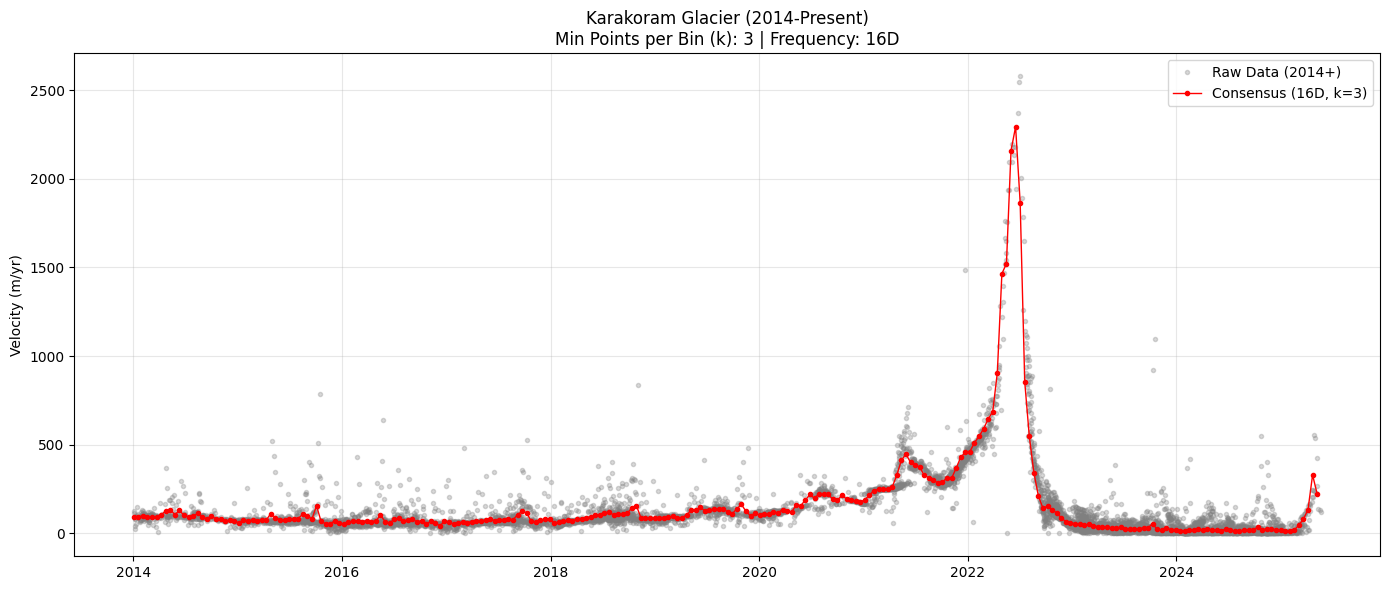

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itslive import velocity_cubes

# ---------------------------------------------------------
# 1. FETCH & FILTER (Post-2014 Only)
# ---------------------------------------------------------
coords = [(71.907, 38.837)] 
print(f"--- STEP 1: FETCHING DATA (2014-Present) ---")

# Fetch data
raw_response = velocity_cubes.get_time_series(points=coords, variables=["v", "mid_date"])[0]
data = raw_response['time_series']

df = pd.DataFrame({
    'date': pd.to_datetime(data['mid_date']),
    'v': np.array(data['v'])
})

# CLEANING
df = df.sort_values('date') 
df = df.dropna()
df = df[df['v'] < 5000] # Physics filter

# *** STRICT 2014 FILTER ***
df = df[df['date'].dt.year >= 2014]

print(f"Total Data Points (2014-Now): {len(df)}")
if len(df) == 0:
    raise ValueError("No data found after 2014 filtering.")

# ---------------------------------------------------------
# 2. TRANSPARENCY CHECK: FINDING 'k'
# ---------------------------------------------------------
print(f"\n--- STEP 2: FINDING MINIMUM POINTS PER BIN (k) ---")
print("Checking how dense the data is for different bin sizes...")

frequencies = ['4D', '8D', '16D', '32D']
best_freq = None
best_k = 0

for freq in frequencies:
    # Group data into bins of size 'freq'
    grouper = df.groupby(pd.Grouper(key='date', freq=freq))
    counts = grouper['v'].count()
    
    # We only care about bins that are NOT empty
    populated_bins = counts[counts > 0]
    
    if populated_bins.empty:
        print(f"  [{freq}] No data found.")
        continue

    # 'k' is the Minimum number of points in the WEAKEST populated bin
    min_k = int(populated_bins.min())
    median_k = int(populated_bins.median())
    max_k = int(populated_bins.max())
    
    # Calculate how many bins would be valid if we required k>=3
    robust_bins = (counts >= 3).sum()
    total_bins = len(counts)
    
    print(f"\n  FREQUENCY: {freq}")
    print(f"    -> Min Points (k): {min_k}  <-- THIS IS YOUR ANSWER")
    print(f"    -> Median Points:  {median_k}")
    print(f"    -> Max Points:     {max_k}")
    print(f"    -> Robust Bins (>=3 pts): {robust_bins}/{total_bins} ({100*robust_bins/total_bins:.1f}%)")

    # Select the first frequency that gives us at least k=3 robustness
    # (Or just take the best we can get if none reach 3)
    if min_k >= 3 and best_freq is None:
        best_freq = freq
        best_k = min_k

# ---------------------------------------------------------
# 3. BUILD CONSENSUS (No Interpolation)
# ---------------------------------------------------------
# If we didn't find a perfect k>=3, we default to 16D or whatever was best
if best_freq is None:
    print("\nWARNING: Even at 32D, some bins have < 3 points.")
    print("Using 16D as a compromise for visualization.")
    best_freq = '16D'
    # Recalculate k for 16D just to be safe for the sampler
    grouper = df.groupby(pd.Grouper(key='date', freq='16D'))
    best_k = int(grouper['v'].count()[lambda x: x > 0].min())

print(f"\n--- STEP 3: BUILDING CONSENSUS USING {best_freq} ---")
print(f"Using Min Count (k) = {best_k}")

grouper = df.groupby(pd.Grouper(key='date', freq=best_freq))
realizations = []
n_iterations = 100

for i in range(n_iterations):
    # Sample 'k' points from every bin. 
    # If a bin has data, take mean of sample. If empty, return NaN.
    sampled = grouper['v'].apply(lambda x: x.sample(n=best_k, replace=True).mean() if len(x) > 0 else np.nan)
    realizations.append(sampled)

# Average the 100 iterations
consensus = pd.concat(realizations, axis=1).mean(axis=1)
df_cons = pd.DataFrame({'v': consensus})

# ---------------------------------------------------------
# 4. PLOT (Gaps Visible)
# ---------------------------------------------------------
plt.figure(figsize=(14, 6))

# Plot raw data
plt.plot(df['date'], df['v'], '.', color='grey', alpha=0.3, label='Raw Data (2014+)')

# Plot consensus (broken lines = gaps)
plt.plot(df_cons.index, df_cons['v'], 'o-', color='red', markersize=3, linewidth=1, label=f'Consensus ({best_freq}, k={best_k})')

plt.title(f"Karakoram Glacier (2014-Present)\nMin Points per Bin (k): {best_k} | Frequency: {best_freq}")
plt.ylabel("Velocity (m/yr)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

1. Configuring Download for fedchenko.zarr...


C:\Users\alian\AppData\Local\Temp\ipykernel_86760\2554835725.py:36: FutureWarning: In a future version, xarray will not decode the variable 'date_dt' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds_cloud = xr.open_dataset(s3_url, engine='zarr', storage_options={'anon': True})


   -> Cleaning metadata to prevent encoding errors...
2. Starting Download (This may take a moment)...
   -> Removing partial download from previous run...
   -> Downloading 4326.21 MB of data...


d:\LUMS\SPROJ\.venv\Lib\site-packages\zarr\api\asynchronous.py:247: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(



✅ Download Complete! Saved to 'fedchenko.zarr'

3. Verifying Local Data...
   -> Successfully loaded 1081348750 measurements.


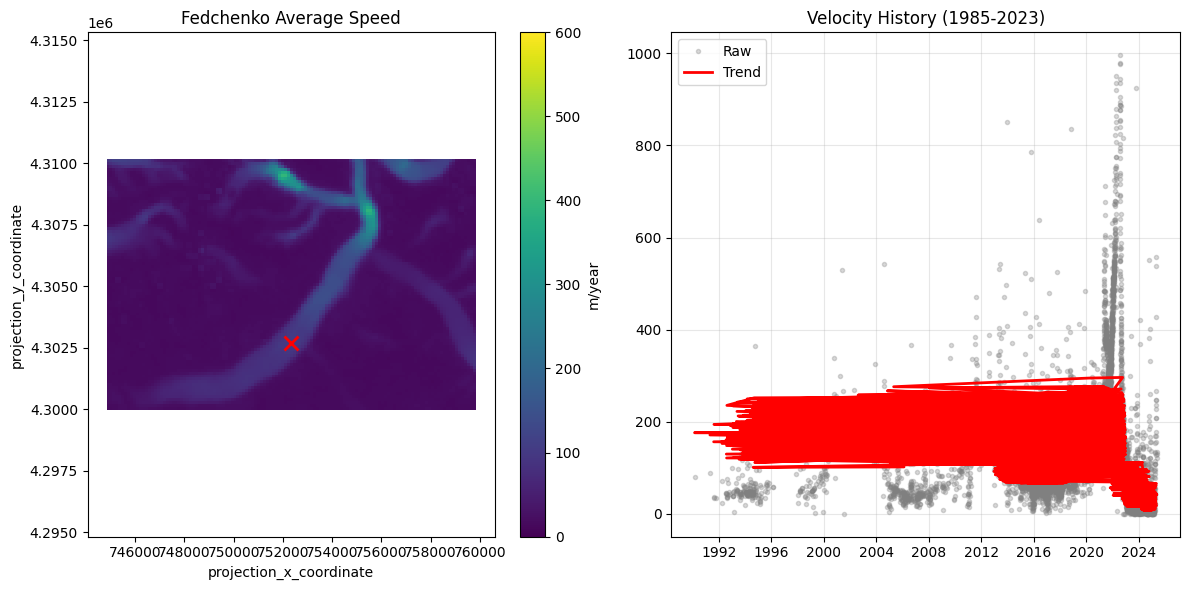

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import pyproj
import numpy as np
import os
import shutil
from dask.diagnostics import ProgressBar

# --- CONFIGURATION ---
# 1. The HTTP URL from your JSON
http_url = "http://its-live-data.s3.amazonaws.com/datacubes/v2-updated-october2024/N30E070/ITS_LIVE_vel_EPSG32642_G0120_X750000_Y4350000.zarr"

# 2. Convert to S3 URL (Critical for Python access)
s3_url = http_url.replace("http://its-live-data.s3.amazonaws.com", "s3://its-live-data")

# 3. Your Target: Fedchenko Glacier
center_lat, center_lon = 38.837, 71.907
box_size_km = 15  
epsg_code = 32642
output_filename = "fedchenko.zarr"

# --- PART 1: SETUP & SLICING ---
print(f"1. Configuring Download for {output_filename}...")

# A. Convert Lat/Lon to Meters
transformer = pyproj.Transformer.from_crs("EPSG:4326", f"EPSG:{epsg_code}", always_xy=True)
center_x, center_y = transformer.transform(center_lon, center_lat)

# B. Calculate Cutout Coordinates
half_size = (box_size_km * 1000) / 2
min_x, max_x = center_x - half_size, center_x + half_size
min_y, max_y = center_y - half_size, center_y + half_size

# C. Connect to Cloud (Lazy Load)
try:
    ds_cloud = xr.open_dataset(s3_url, engine='zarr', storage_options={'anon': True})
    
    # Slice the data (Keep only essential variables)
    subset = ds_cloud[['v', 'mid_date']].sel(
        x=slice(min_x, max_x), 
        y=slice(max_y, min_y)
    )
    
    # --- CRITICAL FIX: STRIP ENCODING ---
    # This prevents the "BytesBytesCodec" error by removing cloud-specific compression settings
    print("   -> Cleaning metadata to prevent encoding errors...")
    for var in subset.variables:
        subset[var].encoding = {}
    
except Exception as e:
    print(f"❌ Error connecting to cloud: {e}")
    exit()

# --- PART 2: ROBUST DOWNLOAD ---
print("2. Starting Download (This may take a moment)...")

# A. Clean up previous failed attempts
if os.path.exists(output_filename):
    print("   -> Removing partial download from previous run...")
    shutil.rmtree(output_filename)

# B. Download with Progress Bar
try:
    # We use Dask's ProgressBar to show real-time status
    print(f"   -> Downloading {(subset.nbytes / 1e6):.2f} MB of data...")
    with ProgressBar():
        subset.to_zarr(output_filename, mode='w', consolidated=True)
    print("\n✅ Download Complete! Saved to 'fedchenko.zarr'")

except Exception as e:
    print(f"\n❌ Download Failed: {e}")
    print("Tip: If internet fails, try reducing 'box_size_km' to 5.")
    exit()

# --- PART 3: VERIFY & ANALYZE ---
print("\n3. Verifying Local Data...")

try:
    # Open the LOCAL file
    ds = xr.open_dataset(output_filename, engine='zarr')
    
    # Check if data exists
    if ds['v'].size == 0:
        print("⚠️ Warning: Downloaded file is empty. Check coordinates.")
    else:
        print(f"   -> Successfully loaded {ds['v'].size} measurements.")
        
        # --- PLOTTING ---
        # 1. Calculate Average Map
        avg_velocity = ds['v'].mean(dim='mid_date')
        
        # 2. Extract Center Point History
        point_data = ds.sel(x=center_x, y=center_y, method='nearest')
        df = point_data.to_dataframe().reset_index().dropna(subset=['v'])
        df = df[df['v'] < 1000] # Filter outliers

        plt.figure(figsize=(12, 6))

        # Left: Map
        plt.subplot(1, 2, 1)
        avg_velocity.plot(cmap='viridis', vmin=0, vmax=600, cbar_kwargs={'label': 'm/year'})
        plt.plot(center_x, center_y, 'rx', markersize=10, markeredgewidth=2)
        plt.title(f"Fedchenko Average Speed")
        plt.axis('equal')

        # Right: Graph
        plt.subplot(1, 2, 2)
        plt.plot(df['mid_date'], df['v'], '.', color='gray', alpha=0.3, label='Raw')
        plt.plot(df['mid_date'], df['v'].rolling(window=20, center=True).mean(), 
                 color='red', linewidth=2, label='Trend')
        plt.title("Velocity History (1985-2023)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"❌ Error reading local file: {e}")

In [5]:
print(ds_cloud)

<xarray.Dataset> Size: 3TB
Dimensions:                     (mid_date: 101774, y: 833, x: 833)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 814kB 2022-08-13T17...
  * y                           (y) float64 7kB 4.4e+06 4.4e+06 ... 4.3e+06
  * x                           (x) float64 7kB 7.001e+05 7.003e+05 ... 8e+05
Data variables: (12/60)
    M11                         (mid_date, y, x) float32 282GB ...
    M11_dr_to_vr_factor         (mid_date) float32 407kB ...
    M12                         (mid_date, y, x) float32 282GB ...
    M12_dr_to_vr_factor         (mid_date) float32 407kB ...
    acquisition_date_img1       (mid_date) datetime64[ns] 814kB ...
    acquisition_date_img2       (mid_date) datetime64[ns] 814kB ...
    ...                          ...
    vy_error_modeled            (mid_date) float32 407kB ...
    vy_error_slow               (mid_date) float32 407kB ...
    vy_error_stationary         (mid_date) float32 407kB ...
    vy_stable_shift   

In [6]:
import xarray as xr
import pyproj
import shutil
import os
from dask.diagnostics import ProgressBar

# --- CONFIGURATION ---
# Target: Fedchenko Glacier
center_lat, center_lon = 38.837, 71.907
box_size_km = 15  

# Define the two overlapping Datacubes
zones_to_download = [
    {
        "name": "Zone_42_Native",
        "epsg": 32642,
        "url": "http://its-live-data.s3.amazonaws.com/datacubes/v2-updated-october2024/N30E070/ITS_LIVE_vel_EPSG32642_G0120_X750000_Y4350000.zarr",
        "output_file": "fedchenko_zone42.zarr"
    },
    {
        "name": "Zone_43_neighbor",
        "epsg": 32643,
        "url": "http://its-live-data.s3.amazonaws.com/datacubes/v2-updated-october2024/N30E070/ITS_LIVE_vel_EPSG32643_G0120_X250000_Y4350000.zarr",
        "output_file": "fedchenko_zone43.zarr"
    }
]

# --- REUSABLE DOWNLOAD FUNCTION ---
def download_cube(zone_info):
    name = zone_info['name']
    epsg = zone_info['epsg']
    filename = zone_info['output_file']
    
    print(f"\n--- PROCESSING: {name} (EPSG:{epsg}) ---")
    
    # 1. Fix URL for Python (HTTP -> S3)
    s3_url = zone_info['url'].replace("http://its-live-data.s3.amazonaws.com", "s3://its-live-data")
    
    # 2. Coordinate Math (Lat/Lon -> Specific UTM Zone)
    # Note: The X/Y values will be totally different for Zone 42 vs 43!
    transformer = pyproj.Transformer.from_crs("EPSG:4326", f"EPSG:{epsg}", always_xy=True)
    center_x, center_y = transformer.transform(center_lon, center_lat)
    
    half_size = (box_size_km * 1000) / 2
    min_x, max_x = center_x - half_size, center_x + half_size
    min_y, max_y = center_y - half_size, center_y + half_size
    
    print(f"   -> Calculated Cutout Center: X={center_x:.0f}, Y={center_y:.0f}")

    # 3. Connect & Slice
    try:
        ds = xr.open_dataset(s3_url, engine='zarr', storage_options={'anon': True})
        
        subset = ds[['v', 'mid_date']].sel(
            x=slice(min_x, max_x), 
            y=slice(max_y, min_y)
        )
        
        # 4. FIX ENCODING (The Robustness Fix)
        for var in subset.variables:
            subset[var].encoding = {}

        # 5. Save to Disk
        if os.path.exists(filename):
            shutil.rmtree(filename)
            
        print(f"   -> Downloading to '{filename}'...")
        with ProgressBar():
            subset.to_zarr(filename, mode='w', consolidated=True)
            
        print(f"   ✅ Success: {name} Saved.")
        
    except Exception as e:
        print(f"   ❌ Failed: {e}")

# --- MAIN EXECUTION ---
for zone in zones_to_download:
    download_cube(zone)

print("\nAll downloads finished.")


--- PROCESSING: Zone_42_Native (EPSG:32642) ---
   -> Calculated Cutout Center: X=752322, Y=4302705


C:\Users\alian\AppData\Local\Temp\ipykernel_86760\620815092.py:52: FutureWarning: In a future version, xarray will not decode the variable 'date_dt' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(s3_url, engine='zarr', storage_options={'anon': True})


   -> Downloading to 'fedchenko_zone42.zarr'...


d:\LUMS\SPROJ\.venv\Lib\site-packages\zarr\api\asynchronous.py:247: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


   ✅ Success: Zone_42_Native Saved.

--- PROCESSING: Zone_43_neighbor (EPSG:32643) ---
   -> Calculated Cutout Center: X=231530, Y=4303235


C:\Users\alian\AppData\Local\Temp\ipykernel_86760\620815092.py:52: FutureWarning: In a future version, xarray will not decode the variable 'date_dt' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(s3_url, engine='zarr', storage_options={'anon': True})


   -> Downloading to 'fedchenko_zone43.zarr'...
   ✅ Success: Zone_43_neighbor Saved.

All downloads finished.


d:\LUMS\SPROJ\.venv\Lib\site-packages\zarr\api\asynchronous.py:247: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


In [8]:
# pip install oggm matplotlib geopandas